# LIBRARIES

In [1]:
import pymongo
from pymongo import MongoClient
import pandas as pd
from pandas.io.json import json_normalize
import folium
from folium import plugins
from folium.plugins import MarkerCluster
import warnings
import requests
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt

In [2]:
client=MongoClient()
db=client.Companies
colec=db.companies

# MONGO QUERIES 

In [3]:
a=list(colec.find({
                    '$and': [
                            {'$or':[{'offices.country_code': 'MEX'},\
                            {'offices.country_code': 'USA'},\
                            {'offices.country_code': 'CAN'}]},\
                    {'founded_year':{'$lte':2012}},\
                    {'number_of_employees':{'$gte':20}},\
                    {'deadpooled_year': None}]},\
                    {'_id':0,'name':1, 'category_code':1, 'number_of_employees':1, 'founded_year':1,'offices.city':1,'offices.latitude':1, 'offices.longitude':1, 'offices.country_code':1}))


# DATA CLEANING / TRANSFORMATION

In [4]:
df=pd.DataFrame(a)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   name                 1988 non-null   object
 1   category_code        1972 non-null   object
 2   number_of_employees  1988 non-null   int64 
 3   founded_year         1988 non-null   int64 
 4   offices              1988 non-null   object
dtypes: int64(2), object(3)
memory usage: 77.8+ KB


In [6]:
df.iloc[1]['offices'] 

[{'city': 'Menlo Park',
  'country_code': 'USA',
  'latitude': 37.41605,
  'longitude': -122.151801},
 {'city': 'Dublin',
  'country_code': 'IRL',
  'latitude': 53.344104,
  'longitude': -6.267494},
 {'city': 'New York',
  'country_code': 'USA',
  'latitude': 40.7557162,
  'longitude': -73.9792469}]

In [7]:
#create a column for every office that a company might have

new_df = pd.DataFrame(index=[], columns=df.columns)

for _, i in df.iterrows():
    
    flattened_d = [dict(i.to_dict(), offices=c) for c in i.offices]
    
    new_df = new_df.append(flattened_d )

In [8]:
new_df.reset_index()

,index,name,category_code,number_of_employees,founded_year,offices
0,0,Digg,news,60,2004,"{'city': 'San Francisco', 'country_code': 'USA..."
1,0,Facebook,social,5299,2004,"{'city': 'Menlo Park', 'country_code': 'USA', ..."
2,1,Facebook,social,5299,2004,"{'city': 'Dublin', 'country_code': 'IRL', 'lat..."
3,2,Facebook,social,5299,2004,"{'city': 'New York', 'country_code': 'USA', 'l..."
4,0,Twitter,social,1300,2006,"{'city': 'San Francisco', 'country_code': 'USA..."
...,...,...,...,...,...,...
3477,0,Atlantic BT,web,30,1998,"{'city': 'Raleigh', 'country_code': 'USA', 'la..."
3478,0,Treehouse,education,55,2011,"{'city': 'Orlando', 'country_code': 'USA', 'la..."
3479,1,Treehouse,education,55,2011,"{'city': 'Portland', 'country_code': 'USA', 'l..."
3480,0,NextLabs,enterprise,100,2004,"{'city': 'San Mateo', 'country_code': 'USA', '..."


In [9]:
#flatten offices column
new_df1=json_normalize(new_df['offices'])

C:\Users\danie\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [10]:
new_df=new_df.reset_index()

In [11]:
new_df.head(5)

,index,name,category_code,number_of_employees,founded_year,offices
0,0,Digg,news,60,2004,"{'city': 'San Francisco', 'country_code': 'USA..."
1,0,Facebook,social,5299,2004,"{'city': 'Menlo Park', 'country_code': 'USA', ..."
2,1,Facebook,social,5299,2004,"{'city': 'Dublin', 'country_code': 'IRL', 'lat..."
3,2,Facebook,social,5299,2004,"{'city': 'New York', 'country_code': 'USA', 'l..."
4,0,Twitter,social,1300,2006,"{'city': 'San Francisco', 'country_code': 'USA..."


In [12]:
new_df1.head(5)

,city,country_code,latitude,longitude
0,San Francisco,USA,37.764726,-122.394523
1,Menlo Park,USA,37.416050,-122.151801
2,Dublin,IRL,53.344104,-6.267494
3,New York,USA,40.755716,-73.979247
4,San Francisco,USA,37.776805,-122.416924


In [13]:
mergedDf = pd.concat([new_df, new_df1], axis=1, sort=False)

In [14]:
bi=mergedDf.drop(columns='offices')

In [15]:
bi=bi.drop(columns='index')

In [16]:
bi.dropna()

,name,category_code,number_of_employees,founded_year,city,country_code,latitude,longitude
0,Digg,news,60,2004,San Francisco,USA,37.764726,-122.394523
1,Facebook,social,5299,2004,Menlo Park,USA,37.416050,-122.151801
2,Facebook,social,5299,2004,Dublin,IRL,53.344104,-6.267494
3,Facebook,social,5299,2004,New York,USA,40.755716,-73.979247
4,Twitter,social,1300,2006,San Francisco,USA,37.776805,-122.416924
...,...,...,...,...,...,...,...,...
3475,VSE Corp,other,1920,1959,Alexandria,USA,38.797792,-77.075720
3476,RF Micro Devices,semiconductor,4095,1991,Greensboro,USA,36.076288,-79.965343
3477,Atlantic BT,web,30,1998,Raleigh,USA,35.896906,-78.680678
3480,NextLabs,enterprise,100,2004,San Mateo,USA,37.553121,-122.301534


In [17]:
bi=bi.loc[(bi['country_code'] == 'USA') | (bi['country_code'] == 'MEX') | (bi['country_code'] == 'CAN')]

In [18]:
bi.info(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2577 entries, 0 to 3481
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 2577 non-null   object 
 1   category_code        2556 non-null   object 
 2   number_of_employees  2577 non-null   object 
 3   founded_year         2577 non-null   object 
 4   city                 2573 non-null   object 
 5   country_code         2577 non-null   object 
 6   latitude             1860 non-null   float64
 7   longitude            1860 non-null   float64
dtypes: float64(2), object(6)
memory usage: 181.2+ KB


In [19]:
bi=bi.dropna(axis=0, subset=['latitude'])

In [20]:
bi['country_code'].value_counts()

USA    1762
CAN      91
MEX       7
Name: country_code, dtype: int64

In [21]:
bi=bi[bi['country_code'] != 'MEX']

In [22]:
bi['country_code'].unique()

array(['USA', 'CAN'], dtype=object)

In [23]:
bi.to_json('bi_project.json') 

In [24]:
#create new collection
db.bootcamp_bi.insert_many(bi.to_dict('records'))

In [25]:
#create 2d index
db.bootcamp_bi.create_index([('principal', '2dsphere')])

'principal_2dsphere'

In [26]:
bi.head()

,name,category_code,number_of_employees,founded_year,city,country_code,latitude,longitude
0,Digg,news,60,2004,San Francisco,USA,37.764726,-122.394523
1,Facebook,social,5299,2004,Menlo Park,USA,37.416050,-122.151801
3,Facebook,social,5299,2004,New York,USA,40.755716,-73.979247
4,Twitter,social,1300,2006,San Francisco,USA,37.776805,-122.416924
5,Scribd,news,50,2007,San Francisco,USA,37.789634,-122.404052


# GEO QUERIES

In [27]:
map_= folium.Map(location=[41.500000, -100.000000],tiles='CartoDB positron', zoom_start=4)

mc = MarkerCluster()

for row in bi.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude, row.longitude], popup=row.name))
 

map_.add_child(mc)

# WEB SCRAPING FOR REAL STATE MARKET RATES

In [28]:
url='https://www.numbeo.com/property-investment/region_rankings.jsp?title=2020&region=021'

res=requests.get(url)
data=res.text
soup=bs(data, 'html.parser')


In [29]:
table=soup.find_all('table', {'class':'stripe'})

In [30]:
table = table[0]

In [71]:
rows=table.find_all('tr')

rows=[r.text.strip().split('\n') for r in rows]

final=[]
for e in rows:
    tmp=[]
    for st in e:
        if st!='':
            tmp.append(st)
    final.append(tmp)
    

In [32]:
city_ranking=pd.DataFrame(final)

In [33]:
city_ranking.head()

,0,1,2,3,4,5,6,7,8
0,Rank,City,Price To Income Ratio,Gross Rental Yield City Centre,Gross Rental Yield Outside of Centre,Price To Rent Ratio City Centre,Price To Rent Ratio Outside Of City Centre,Mortgage As A Percentage Of Income,Affordability Index
1,"Vancouver, Canada",14.34,3.61,3.70,27.72,26.99,102.30,0.98,None
2,"Toronto, Canada",13.91,4.15,4.18,24.08,23.91,95.31,1.05,None
3,"Coquitlam, Canada",11.20,4.74,4.48,21.10,22.32,79.95,1.25,None
4,"New York, NY, United States",10.76,4.91,5.74,20.38,17.43,79.38,1.26,None


In [34]:
city_ranking=city_ranking.rename(columns={0: "City", 1: "Price To Income Ratio",2 : 'Gross Rental Yield City Centre',3 : 'Gross Rental Yield Outside of Centre', 4: 'Price To Rent Ratio City Centre', 5: 'Price To Rent Ratio Outside Of City Centre', 6: 'Mortgage As A Percentage Of Income', 7: 'Affordability Index'})

In [35]:
city_ranking.drop([0],inplace =True)

In [36]:
city_ranking.drop([8], axis = 1, inplace = True)

In [37]:
city_ranking.head(50)

,City,Price To Income Ratio,Gross Rental Yield City Centre,Gross Rental Yield Outside of Centre,Price To Rent Ratio City Centre,Price To Rent Ratio Outside Of City Centre,Mortgage As A Percentage Of Income,Affordability Index
1,"Vancouver, Canada",14.34,3.61,3.70,27.72,26.99,102.30,0.98
2,"Toronto, Canada",13.91,4.15,4.18,24.08,23.91,95.31,1.05
3,"Coquitlam, Canada",11.20,4.74,4.48,21.10,22.32,79.95,1.25
4,"New York, NY, United States",10.76,4.91,5.74,20.38,17.43,79.38,1.26
5,"Brooklyn, NY, United States",10.33,5.01,6.76,19.97,14.78,77.10,1.30
6,"Burnaby, Canada",9.59,4.34,5.34,23.06,18.72,68.12,1.47
7,"Honolulu, HI, United States",9.32,5.12,6.18,19.53,16.18,70.03,1.43
8,"Brampton, Canada",8.78,5.59,6.09,17.88,16.42,62.39,1.60
9,"Mississauga, Canada",8.43,5.77,5.65,17.34,17.69,59.49,1.68
10,"Sunnyvale, CA, United States",8.39,4.53,4.62,22.09,21.62,63.29,1.58


In [38]:
for r in city_ranking['Price To Rent Ratio City Centre']:
    r.strip()

In [39]:
price_rent=city_ranking[['City','Price To Rent Ratio City Centre']].sort_values(by='Price To Rent Ratio City Centre').head(30)

In [40]:
price_rent['Price To Rent Ratio City Centre']=price_rent['Price To Rent Ratio City Centre'].astype(float)

In [42]:
price_rent.sort_values(by='Price To Rent Ratio City Centre', inplace=True)

In [43]:
price_rent=price_rent.head(20)

#Best Price To Rent Ratio Centre

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

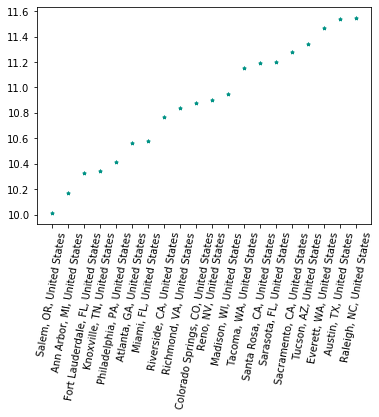

In [44]:
x=price_rent['City']
y=price_rent['Price To Rent Ratio City Centre']
plt.scatter(x,y,s=12, c='#029386', marker='*',linewidths=1)
plt.xticks(rotation=80)

In [45]:
Austin_df=bi.loc[(bi['city'] == 'Austin')]

In [46]:
Austin_df.reset_index(inplace=True)

In [47]:
Austin_df.drop(columns='index',inplace=True)

C:\Users\danie\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [53]:
Austin_df

,name,category_code,employees,founded_year,city,country_code,latitude,longitude
0,Google,search,28000,1998,Austin,USA,30.351416,-97.751382
1,Bazaarvoice,software,600,2005,Austin,USA,30.407545,-97.717667
2,Springbox,web,65,2004,Austin,USA,30.269452,-97.742682
3,Yodle,advertising,1000,2005,Austin,USA,30.378658,-97.731249
4,BreakingPoint Systems,security,109,2005,Austin,USA,30.384453,-97.709809
5,SKYLIST,web,65,1996,Austin,USA,30.267200,-97.742306
6,Adlucent,software,85,2005,Austin,USA,30.316226,-97.718130
7,Absolute Software,software,300,1993,Austin,USA,30.265006,-97.746608
8,Razorfish,consulting,2000,1995,Austin,USA,30.269026,-97.745671
9,FIRST ROI,advertising,100,2006,Austin,USA,30.432421,-97.732059


In [63]:
Austin_df['category_code'].value_counts()

software          18
enterprise         6
web                4
advertising        3
education          2
consulting         2
transportation     2
other              2
semiconductor      2
ecommerce          2
security           1
hardware           1
search             1
analytics          1
Name: category_code, dtype: int64

In [49]:
Austin_df.rename(columns={'number_of_employees' : 'employees'}, inplace=True)

C:\Users\danie\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# SUGGESTED LOCATION

In [70]:
map_austin= folium.Map(location=[30.2671509, -97.7430573], zoom_start=11)
#mc = MarkerCluster()

lat=30.288159
lon=-97.750154

for row in Austin_df.itertuples():
        folium.Marker(location=[row.latitude, row.longitude], popup="Company:" 
                                                                            + row.name + " " 
                                                                            + "Category:" 
                                                                            + row.category_code).add_to(map_austin)
folium.Circle([lat,lon],
                    radius=5000
                   ).add_to(map_austin)
    

map_austin
